In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from obspy import UTCDateTime
from matplotlib import pyplot as plt
import ground_motion_qh
from ground_motion_qh.get_waveforms import get_stream_multiple_stations, raw_stream_to_amplitude_and_times
import os
from pathlib import Path
from pprint import pprint
import pickle

base_dir = Path(ground_motion_qh.__file__).parent.parent

In [ ]:
# ADD YOUR PICKS HERE:

pick_times = get_pick_times() #...or whatever as a numpy datetime array


In [2]:
download_name = "ANZA_SND_1994_M4"

# check if the folder already exists in the raw data folder
data_dir = base_dir / "data" / "raw_data" / download_name
if data_dir.exists():
    print(f"Folder {download_name} already exists in the raw data folder.")

# MAKE SURE TO CHANGE STATION LOCATION ALONG WITH THE STATION NAME!
station_metadata = dict(
    stname = ["SND"],
    network = "AZ",
    org = "IRIS",
    latitude = 33.5519,
    longitude = -116.6129,
    start_time = '1982-10-01',
    number_of_tries = 2,
)

# explanation of buffers:

# (hypocenter) t1                                                                                            t2
# t0 time shift    pre-buffer     event time window     mid buffer     forecast time window      post buffer
# |------------||--------------||-------------------||--------------||---------- ... ---------||-------------|

analysis_metadata = dict(
    mid_buffer = 20,
    forecast_time_window = 60*60,
    event_time_window = 30,
    shift_times = False,
)

analysis_metadata["pre_buffer"] = 3*0.05 * analysis_metadata["forecast_time_window"] + analysis_metadata["event_time_window"] + analysis_metadata["mid_buffer"]
analysis_metadata["post_buffer"] = 3*0.05 * analysis_metadata["forecast_time_window"] + analysis_metadata["event_time_window"] + analysis_metadata["mid_buffer"]


In [3]:
pprint(analysis_metadata, width=1)

{'event_time_window': 30,
 'forecast_time_window': 3600,
 'mid_buffer': 20,
 'post_buffer': 590.0000000000001,
 'pre_buffer': 590.0000000000001,
 'shift_times': True}


In [4]:
metadata = dict(
    analysis_metadata = analysis_metadata,
    station_metadata = station_metadata,
)

# create a data directory with and save the metadata
data_dir = base_dir / "data" / "raw_data" / download_name
os.makedirs(data_dir, exist_ok=True)
np.save(data_dir / "metadata.npy", metadata)

In [10]:
minus_time_range = [
    analysis_metadata["pre_buffer"],
    analysis_metadata["pre_buffer"] + analysis_metadata["event_time_window"]
]

plus_time_range = [
    analysis_metadata["pre_buffer"] + analysis_metadata["event_time_window"],
    analysis_metadata["pre_buffer"] + analysis_metadata["event_time_window"] + analysis_metadata["mid_buffer"]
]

In [ ]:
a_max_minus = []
a_max_plus = []

for i, t1 in pick_times:
    print(f"Dowloading event {i}: {t1}")
    
    t2 = t1 + np.timedelta64(
        int(  # (QUAKE) HACK
            analysis_metadata["pre_buffer"]
            + analysis_metadata["event_time_window"]
            + analysis_metadata["mid_buffer"]
            + analysis_metadata["forecast_time_window"]
            + analysis_metadata["post_buffer"]
        ),
        "s",
    )

    # preprocess the waveforms
    i = 0
    while i < station_metadata["number_of_tries"]:
        try:
            stream_dict = get_stream_multiple_stations(
                t1=UTCDateTime(t1),
                t2=UTCDateTime(t2),
            )

            event_dir = data_dir / f"data/{t1.strftime('%Y-%m-%d_%H-%M-%S')}"

            os.makedirs(event_dir, exist_ok=True)

            with open(event_dir / "stream_dict.pkl", "wb") as f:
                pickle.dump(stream_dict, f)

            amplitude, times = raw_stream_to_amplitude_and_times(stream_dict["SND"])
            np.save(event_dir / "amplitude.npy", amplitude)
            np.save(event_dir / "times.npy", times)

            minus_time_range = [
                analysis_metadata["pre_buffer"],
                analysis_metadata["pre_buffer"]
                + analysis_metadata["event_time_window"],
            ]

            plus_time_range = [
                analysis_metadata["pre_buffer"]
                + analysis_metadata["event_time_window"],
                analysis_metadata["pre_buffer"]
                + analysis_metadata["event_time_window"]
                + analysis_metadata["mid_buffer"],
            ]

            a_minus = amplitude[
                (times >= minus_time_range[0]) & (times <= minus_time_range[1])
            ]
            a_plus = amplitude[
                (times >= plus_time_range[0]) & (times <= plus_time_range[1])
            ]

            a_max_minus.append(
                np.max(a_minus)
            )  # note that the instrument response is removed, then we detrend, and hi
            a_max_plus.append(np.max(a_plus))

        except Exception as e:
            print(f"Error dowloading event {i}: {e}")

        i += 1

In [12]:
np.save(data_dir / "a_max_minus.npy", np.array(a_max_minus))
np.save(data_dir / "a_max_plus.npy", np.array(a_max_plus))

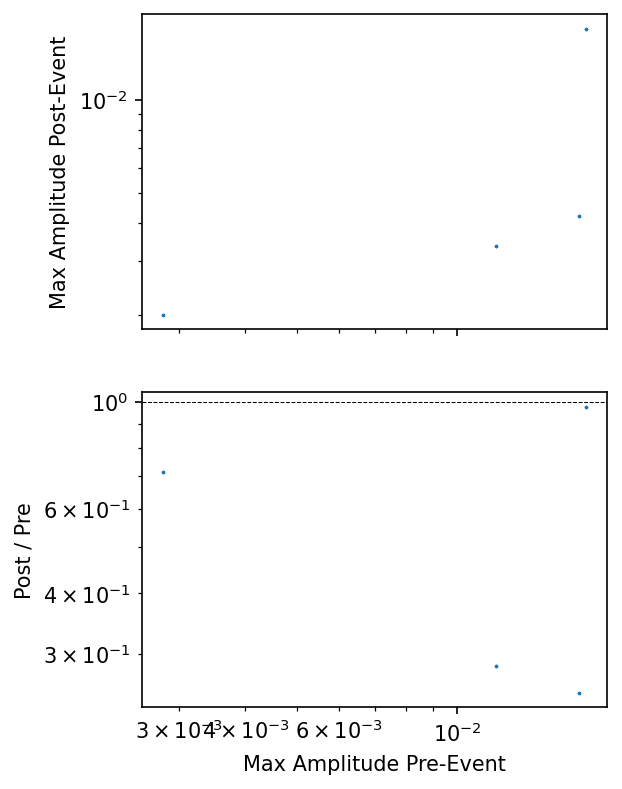

In [13]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=(4, 6), dpi=150)
ax[0].scatter(np.array(a_max_minus), np.array(a_max_plus), s=0.5)
ax[0].set(
    xscale="log", 
    yscale="log",
    ylabel="Max Amplitude Post-Event",
)

ax[1].scatter(np.array(a_max_minus), np.array(a_max_plus)/np.array(a_max_minus), s=0.5)
ax[1].set(
    xscale="log", 
    yscale="log",
    xlabel="Max Amplitude Pre-Event",
    ylabel="Post / Pre",
)
ax[1].axhline(1, color="k", linestyle="--", lw=0.5)



In [14]:
# This goes in analysis file

# for each file in REPO 

# load stream

# split into parts

# calculate shaking intensity (e.g. PGV)